# <font color='CornflowerBlue'> Diapers or beer. Practical project of creating recommendation system

Загружаем данные Amazon с рейтингами по журнальным подпискам

In [23]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator

In [24]:
df = pd.read_csv('Magazine_Subscriptions.csv', names=['item', 'user', 'rating', 'timestamp'])
df.head()

,item,user,rating,timestamp
0,B00005N7P0,AH2IFH762VY5U,5.0,1005177600
1,B00005N7P0,AOSFI0JEYU4XM,5.0,1004486400
2,B00005N7OJ,A3JPFWKS83R49V,3.0,1174694400
3,B00005N7OJ,A19FKU6JZQ2ECJ,5.0,1163116800
4,B00005N7P0,A25MDGOMZ2GALN,5.0,1405296000


In [25]:
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,item,user,rating,timestamp
0,B00005N7P0,AH2IFH762VY5U,5.0,2001-11-08
1,B00005N7P0,AOSFI0JEYU4XM,5.0,2001-10-31
2,B00005N7OJ,A3JPFWKS83R49V,3.0,2007-03-24
3,B00005N7OJ,A19FKU6JZQ2ECJ,5.0,2006-11-10
4,B00005N7P0,A25MDGOMZ2GALN,5.0,2014-07-14


Перекодируем id журналов и пользователей в числовой формат

In [26]:
enc = OrdinalEncoder()
enc.fit(df[['item', 'user']])
df[['item', 'user']] = enc.fit_transform(df[['item', 'user']]).astype('int64')

### Exploratory data analisys

In [27]:
df.describe()

,item,user,rating
count,89689.000000,89689.000000,89689.000000
mean,826.059216,36034.711102,4.036638
std,662.396617,20773.837732,1.419791
min,0.000000,0.000000,1.000000
25%,134.000000,18028.000000,3.000000
50%,800.000000,36018.000000,5.000000
75%,1320.000000,53989.000000,5.000000
max,2427.000000,72097.000000,5.000000


In [28]:
df.isna().sum()

item         0
user         0
rating       0
timestamp    0
dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89689 entries, 0 to 89688
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   item       89689 non-null  int64         
 1   user       89689 non-null  int64         
 2   rating     89689 non-null  float64       
 3   timestamp  89689 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.7 MB


In [30]:
df['rating'].unique()

array([5., 3., 4., 2., 1.])

In [31]:
df['rating'] = df['rating'].astype('int32')

In [32]:
df.duplicated().sum()

1221

In [33]:
df.drop_duplicates(inplace=True)

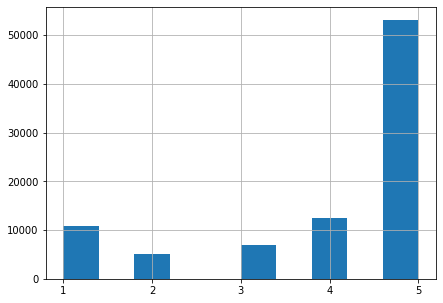

In [34]:
df['rating'].hist(figsize=(7,5))
plt.xticks(range(1,6))
plt.show()

In [35]:
print('Количество уникальных журналов составляет {}'.format(len(df.item.unique())), end='\n\n')
print('Количество уникальных читателей составляет {}'.format(len(df.user.unique())))

Количество уникальных журналов составляет 2428

Количество уникальных читателей составляет 72098


### Modeling

Посмотрим на качество двух базовых моделей: со средним и медианным значениями

In [36]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

print("RMSE базовой модели со средним значением составляет {:.2f}".format(rmse(df.rating, df.rating.mean())), end='\n\n')
print("RMSE базовой модели с медианным значением составляет {:.2f}".format(rmse(df.rating, df.rating.median())))

RMSE базовой модели со средним значением составляет 1.42

RMSE базовой модели с медианным значением составляет 1.71


Разбиваем датасет на обучающую и тестовую выборки - в тест попадают последние по времени записи без учета пользователей, т.к. много пользователей всего с 1 оцененным журналом

In [37]:
df.sort_values(by=['timestamp'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df[['user', 'item']], df['rating'], test_size=0.25, random_state=800, shuffle=False)

X_train.shape, len(y_train), X_test.shape, len(y_test)

((66351, 2), 66351, (22117, 2), 22117)

Создаем класс для построения User-based модели

In [38]:
class UserBased(BaseEstimator):
    def fit(self, X, y, user_col='user', item_col='item'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку пользователя
        X['y'] -= X[user_col].apply(lambda x: self.mean_y_user[x])
        
        # создаём векторы для каждого пользователя из просмотренных фильмов
        # для неизвестных фильмов ставим оценку 0
        self.user_ratings = pd.pivot_table(X, values='y', index=user_col,
                                           columns=item_col, fill_value=0)
        
        # считаем попарную схожесть между юзерами
        self.user_sim = cosine_similarity(self.user_ratings)
        
        # также сделаем словарь - {значение user_col: index в user_ratings}
        self.user_pos = dict()
        for user in self.users:
            self.user_pos[user] = np.argwhere(self.user_ratings.index.values == user)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.user_sim[self.user_pos[pr_user]]).sum() - 1
        
        return self.mean_y_user[pr_user] + numerator / denominator
    
    def predict(self, X, user_col='user', item_col='item'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

Модель User-Based обучалась на части данных - на полном наборе вылетает ошибка по kernel'у.
В данном датасете много уникальных читателей, т.о. получается много нулевых рейтингов в предсказаниях. Для корректной оценки качества модели нужно брать рейтинги более 0.

In [39]:
ub = UserBased().fit(X_train[:35000], y_train[:35000])
pred = ub.predict(X_test)
print('rmse = {:.2f}'.format(rmse(y_test[pred[pred > 0].index], pred[pred > 0])))

rmse = 1.46


Создаем класс для построения Item-based модели

In [40]:
class ItemBased(BaseEstimator):
    def fit(self, X, y, user_col='user', item_col='item'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку предмета
        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])
        
        # создаём векторы для каждого фильма с оценками пользователя
        # если пользователь не поставил оценку, то ставим 0
        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)
        
        # считаем попарную схожесть между фильмами
        self.item_sim = cosine_similarity(self.item_ratings)
        
        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.item_sim[self.item_pos[pr_item]]).sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    
    def predict(self, X, user_col='user', item_col='item'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [41]:
ub = ItemBased().fit(X_train, y_train)
pred = ub.predict(X_test)
print('rmse = {:.2f}'.format(rmse(y_test[pred[pred > 0].index], pred[pred > 0])))

C:\Users\AVProkopenko\AppData\Local\Temp\ipykernel_12268\3681805250.py:43: RuntimeWarning: invalid value encountered in double_scalars
  return self.mean_y_item[pr_item] + numerator / denominator


rmse = 1.36


### Лучшее качество (RMSE 1.36) показала Item-based модель